In [2]:
import sys
import numpy
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import numpy as np
import scipy.sparse as sp
from torch_geometric.data import Data
import numpy
import scipy
import torch
import pickle
import glob
import os
import re
from itertools import combinations
from collections import defaultdict
from torch_geometric.nn import GCNConv
from torch_geometric.utils import from_networkx
from torch_geometric.loader import DataLoader
import networkx as nx
from networkx.algorithms.community import modularity
from torch_geometric.explain import (
    Explainer,
    GNNExplainer,
    ModelConfig,
    CaptumExplainer,
    DummyExplainer,
    unfaithfulness,
    fidelity,
)
from torch_geometric.utils import from_networkx
import captum

from tqdm.notebook import tqdm
from sklearn.metrics import (
    silhouette_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
)
from sklearn.cluster import KMeans

from src.ZoneTransformer import zt

os.environ["OMP_NUM_THREADS"] = (
    "1"  # Limit to 1 thread to avoid conflicts in notebook environment
)

In [3]:
teams = [1609, 1612, 1625]

In [4]:
folder_path = "./graphs"

team_graphs = defaultdict(list)

pattern = re.compile(r"team(\d+)\.pkl")

for G in glob.glob(os.path.join(folder_path, "graph_match*_team*.pkl")):
    match = pattern.search(G)
    if match:
        team_id = int(match.group(1))  # convert to integer if needed
        with open(G, "rb") as f:
            graph = pickle.load(f)
        team_graphs[team_id].append(graph)

print(f"Loaded graphs for {len(team_graphs)} teams:")
for team_id, graphs in team_graphs.items():
    print(f"  Team {team_id}: {len(graphs)} graphs")

Loaded graphs for 3 teams:
  Team 1609: 38 graphs
  Team 1625: 37 graphs
  Team 1612: 37 graphs


In [ ]:
def prepare_pyg_data(G, add_spatial=True, add_topo=True):
    """
    Converts a zone transition graph into a PyTorch Geometric Data object.
    Includes structural, statistical, and spatial node features.
    """

    features = []

    # Optionally precompute graph-level topological measures
    if add_topo:
        clustering = nx.clustering(G, weight="weight")
        pagerank = nx.pagerank(G, weight="weight")

    for n in G.nodes():
        # --- Structural degrees ---
        in_deg = G.in_degree(n, weight="weight")
        out_deg = G.out_degree(n, weight="weight")
        total_w = in_deg + out_deg

        # --- From your existing node attributes ---
        event_count = G.nodes[n].get("event_count", 0)
        unique_players = G.nodes[n].get("unique_players", 0)

        # Role distribution (GK, DF, MD, FW)
        role_dist = G.nodes[n].get("role_distribution", [0, 0, 0, 0])

        # Encode most_common_event (categorical) → one-hot
        event_type = G.nodes[n].get("most_common_event", None)
        event_types = [
            "pass",
            "shot",
            "dribble",
            "cross",
            "duel",
        ]  # adjust for your dataset
        event_onehot = [1.0 if event_type == et else 0.0 for et in event_types]

        # --- Optional spatial coordinates ---
        if zt is not None and add_spatial:
            x_center, y_center = zt.get_zone_center(n)
            x_center, y_center = x_center / 100, y_center / 100
        else:
            x_center, y_center = 0.0, 0.0

        # --- Optional topological measures ---
        if add_topo:
            cluster_coeff = clustering.get(n, 0.0)
            pr = pagerank.get(n, 0.0)
        else:
            cluster_coeff = pr = 0.0

        # --- Combine all features ---
        features.append(
            [
                in_deg,
                out_deg,
                total_w,
                event_count,
                unique_players,
                cluster_coeff,
                pr,
                *role_dist,
                *event_onehot,
                x_center,
                y_center,
            ]
        )

    X = torch.tensor(np.array(features, dtype=float), dtype=torch.float32)

    # Build PyG Data
    data = from_networkx(G)
    data.x = X

    # Edge attributes (weights)
    data.edge_attr = torch.tensor(
        [G[u][v].get("weight", 1.0) for u, v in G.edges()], dtype=torch.float32
    )

    return data

In [5]:
def prepare_pyg_data(G):
    """
    Converts a zone transition graph into a PyTorch Geometric Data object.
    Includes node features + edge weights.
    """

    features = []
    for n in G.nodes():
        node = G.nodes[n]
        in_deg, out_deg = node["in_deg"], node["out_deg"]
        x_center, y_center = node["x_center"], node["y_center"]
        event_count = node["event_count"]
        unique_players = node["unique_players"]
        role_dist = node["role_distribution"]
        event_dist = node["event_distribution"]

        features.append(
            [
                in_deg,
                out_deg,
                x_center,
                y_center,
                event_count,
                unique_players,
                *role_dist,
                *event_dist,
            ]
        )

    X = torch.tensor(np.array(features, dtype=float), dtype=torch.float32)

    data = from_networkx(G)
    data.x = X

    # add edge weights as attributes
    edge_weights = [G[u][v]["weight"] for u, v in G.edges()]
    data.edge_attr = torch.tensor(edge_weights, dtype=torch.float32)

    return data

In [6]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, latent_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, latent_channels)

    def forward(self, x, edge_index, edge_weight=None):
        x = F.relu(self.conv1(x, edge_index, edge_weight=edge_weight))
        z = self.conv2(x, edge_index, edge_weight=edge_weight)
        return z


class GraphAutoencoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, latent_channels):
        super().__init__()
        self.encoder = GCNEncoder(in_channels, hidden_channels, latent_channels)

    def forward(self, data):
        z = self.encoder(data.x, data.edge_index, data.edge_attr)
        # adjacency reconstruction (inner product)
        adj_pred = torch.sigmoid(torch.mm(z, z.t()))
        return adj_pred, z


def train_team_autoencoder(
    team_graphs,
    zt=None,
    hidden_dim=16,
    latent_dim=3,
    epochs=200,
    lr=0.005,
    batch_size=1,
    device="cpu",
    save_path=None,
):
    if save_path and os.path.exists(save_path):
        print(f"Loading existing model from {save_path}")
        model = pickle.load(open(save_path, "rb"))
        return model

    data_list = [prepare_pyg_data(G) for G in team_graphs]
    loader = DataLoader(data_list, batch_size=batch_size, shuffle=True)

    # model setup
    in_dim = data_list[0].x.shape[1]
    model = GraphAutoencoder(in_dim, hidden_dim, latent_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # training loop
    model.train()
    for epoch in tqdm(range(epochs), desc="Training GCN Autoencoder"):
        total_loss = 0
        for data in loader:
            data = data.to(device)
            optimizer.zero_grad()
            A_pred, _ = model(data)

            # Ground-truth adjacency
            A_true = torch.zeros_like(A_pred)
            for i, (u, v) in enumerate(data.edge_index.t()):
                A_true[u, v] = 1.0

            loss = F.mse_loss(A_pred, A_true)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

    pickle.dump(model, open(save_path, "wb"))

    return model


def get_team_embeddings(model, team_graphs, zt=None, device="cpu"):
    model.eval()
    embeddings_per_match = []
    with torch.no_grad():
        for G in team_graphs:
            data = prepare_pyg_data(G).to(device)
            _, z = model(data)
            # instead of .numpy(), just keep as list
            embeddings_per_match.append(z.cpu().tolist())
    return embeddings_per_match

In [7]:
model_1609 = train_team_autoencoder(
    team_graphs[1609],
    zt,
    epochs=200,
    save_path="models/gcn_adjacency_team_1609.pkl",
)
model_1612 = train_team_autoencoder(
    team_graphs[1612],
    zt,
    epochs=200,
    save_path="models/gcn_adjacency_team_1612.pkl",
)
model_1625 = train_team_autoencoder(
    team_graphs[1625],
    zt,
    epochs=200,
    save_path="models/gcn_adjacency_team_1625.pkl",
)

Loading existing model from models/gcn_adjacency_team_1609.pkl
Loading existing model from models/gcn_adjacency_team_1612.pkl
Loading existing model from models/gcn_adjacency_team_1625.pkl


In [8]:
def compute_team_embeddings(embeddings_per_match):
    """
    Average node embeddings across matches for consistent team-level representation.
    embeddings_per_match: list of matches, each is list of node embeddings per node
    Returns: np.array of shape (num_zones, latent_dim)
    """
    zone_embeddings_dict = defaultdict(list)
    for match_emb in embeddings_per_match:
        for node_id, z in enumerate(match_emb):
            zone_embeddings_dict[node_id].append(z)

    num_zones = max(zone_embeddings_dict.keys()) + 1
    latent_dim = len(next(iter(zone_embeddings_dict.values()))[0])
    team_embeddings = np.zeros((num_zones, latent_dim))

    for node_id, emb_list in zone_embeddings_dict.items():
        team_embeddings[node_id] = np.mean(emb_list, axis=0)

    return team_embeddings


def visualize_clusters(G, labels, figsize=(12, 8), title="Zone clustering"):
    """
    G: NetworkX graph (canonical team graph with all zones)
    labels: 1D array of cluster IDs per node
    zt: optional object with get_zone_center(node)
    """
    plt.figure(figsize=figsize)

    pos = {n: zt.get_zone_center(n) for n in G.nodes()}

    labels = np.array(labels)
    colors = plt.cm.tab10(labels.astype(int) % 10)

    nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=800, alpha=0.9)
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    nx.draw_networkx_labels(G, pos, font_size=10)

    plt.title(title)
    plt.axis("off")
    plt.show()

In [9]:
embeddings_1609 = get_team_embeddings(model_1609, team_graphs[1609], zt)
embeddings_1612 = get_team_embeddings(model_1612, team_graphs[1612], zt)
embeddings_1625 = get_team_embeddings(model_1625, team_graphs[1625], zt)

embeddings = {1609: embeddings_1609, 1612: embeddings_1612, 1625: embeddings_1625}

In [10]:
def cluster_and_visualize(team_id: int, n_clusters=5):
    embeddings_per_match = embeddings[team_id]
    team_embeddings = compute_team_embeddings(embeddings_per_match)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)

    cluster_ids = kmeans.fit_predict(team_embeddings)

    num_zones = team_embeddings.shape[0]

    canonical_graph = nx.Graph()
    canonical_graph.add_nodes_from(graphs[0].nodes(data=True))
    canonical_graph.add_edges_from(graphs[0].edges(data=True))

    nodes_in_graph = list(canonical_graph.nodes())
    cluster_ids_filtered = [cluster_ids[n] for n in nodes_in_graph]

    visualize_clusters(
        canonical_graph,
        cluster_ids_filtered,
        title=f"Team {team_id} zone clusters",
    )

    return cluster_ids, canonical_graph

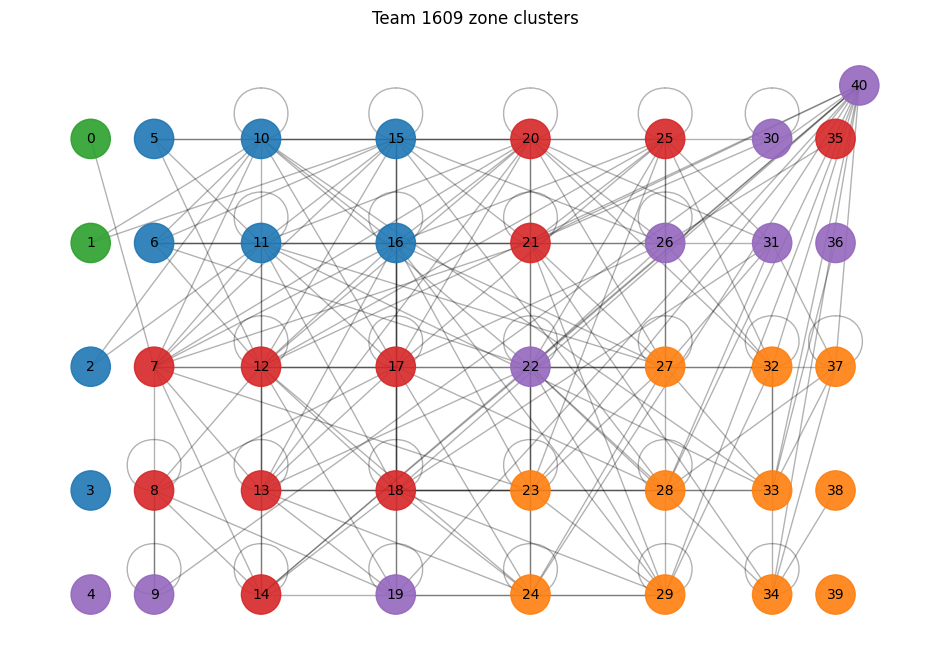

In [11]:
clusters_1609, cgraph_1609 = cluster_and_visualize(1609, n_clusters=5)

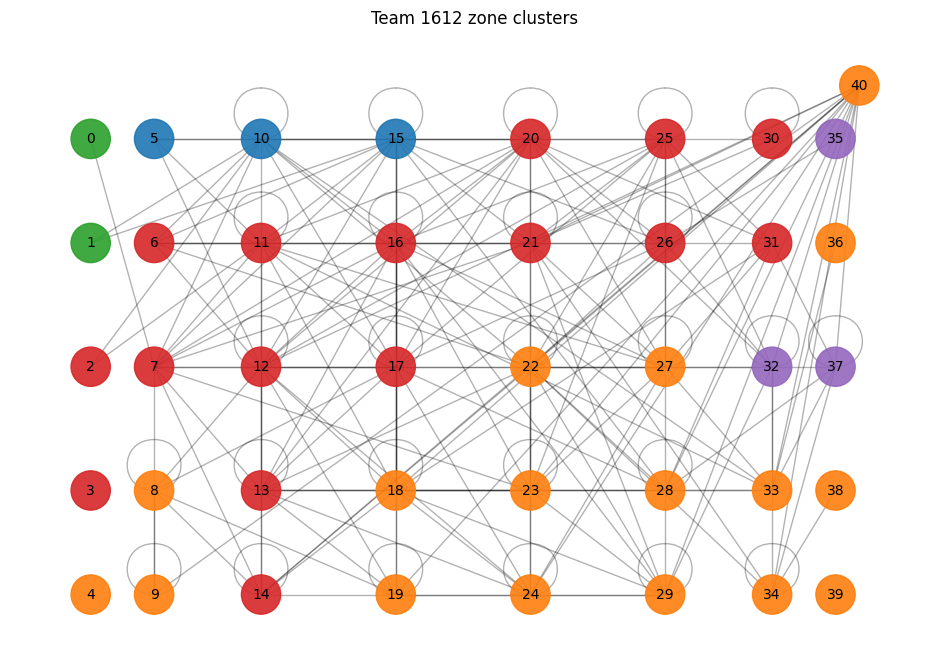

In [12]:
clusters_1612, cgraph_1612 = cluster_and_visualize(1612, n_clusters=5)

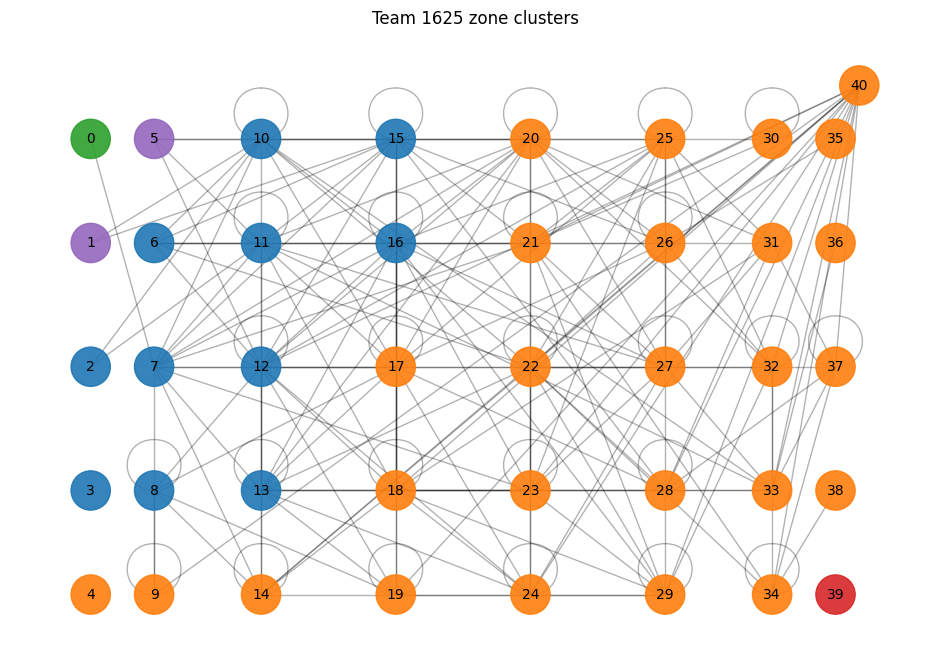

In [13]:
clusters_1625, cgraph_1625 = cluster_and_visualize(1625, n_clusters=5)

In [14]:
def evaluate_silhouette(embeddings, cluster_ids):
    """
    embeddings: numpy array of shape (n_nodes, latent_dim)
    cluster_ids: array of shape (n_nodes,)
    """
    if len(np.unique(cluster_ids)) < 2:
        print("Silhouette score not defined for a single cluster.")
        return None
    return silhouette_score(embeddings, cluster_ids)

In [15]:
def evaluate_ari(cluster_ids, ground_truth_labels):
    """
    cluster_ids: predicted cluster IDs
    ground_truth_labels: known labels (same length)
    """
    return adjusted_rand_score(ground_truth_labels, cluster_ids)

In [16]:
def evaluate_modularity(G, cluster_ids):
    """
    G: networkx Graph
    cluster_ids: array of cluster IDs per node
    """
    # Group nodes by cluster
    communities = []
    labels = np.array(cluster_ids)
    for c in np.unique(labels):
        communities.append(set(np.where(labels == c)[0]))

    # Compute modularity
    return modularity(G, communities)

In [17]:
def evaluate_team_clustering(team_name, embeddings, cluster_ids, G=None):
    print(f"\n=== Evaluating clustering for {team_name} ===")

    try:
        sil = silhouette_score(embeddings, cluster_ids)
        print(f"Silhouette score: {sil:.3f}")
    except Exception as e:
        print(f"Silhouette score could not be computed: {e}")

    print("ARI requires ground truth, skipping unless available.")

    if G is not None:
        valid_nodes = list(G.nodes())
        node_id_to_index = {n: i for i, n in enumerate(valid_nodes)}

        # filter cluster_ids to match only existing nodes
        valid_cluster_ids = [
            cluster_ids[i] for i in node_id_to_index.values() if i < len(cluster_ids)
        ]

        # build partition
        communities = []
        for c in np.unique(valid_cluster_ids):
            comm_nodes = [
                n for n, cid in zip(valid_nodes, valid_cluster_ids) if cid == c
            ]
            if len(comm_nodes) > 0:
                communities.append(set(comm_nodes))

        try:
            mod = nx.community.modularity(G, communities)
            print(f"Modularity: {mod:.3f}")
        except Exception as e:
            print(f"Modularity computation failed: {e}")

In [18]:
def get_average_node_embeddings(embeddings_per_match):
    """
    embeddings_per_match: list of arrays (num_nodes, latent_dim)
    Returns averaged embedding per node ID
    """
    # find the max node index (assuming node IDs start at 0)
    max_nodes = max(e.shape[0] for e in embeddings_per_match)
    latent_dim = embeddings_per_match[0].shape[1]

    # initialize accumulators
    sums = np.zeros((max_nodes, latent_dim))
    counts = np.zeros(max_nodes)

    # accumulate embeddings per node across matches
    for emb in embeddings_per_match:
        for i in range(emb.shape[0]):
            sums[i] += emb[i]
            counts[i] += 1

    # avoid division by zero
    counts[counts == 0] = 1
    avg_embeddings = sums / counts[:, None]
    return avg_embeddings

In [19]:
avg_embeddings_1609 = get_average_node_embeddings(
    [np.array(match_emb) for match_emb in embeddings_1609]
)

avg_embeddings_1612 = get_average_node_embeddings(
    [np.array(match_emb) for match_emb in embeddings_1612]
)

avg_embeddings_1625 = get_average_node_embeddings(
    [np.array(match_emb) for match_emb in embeddings_1625]
)

In [20]:
for t in teams:
    evaluate_team_clustering(
        f"Team {t}",
        eval(f"avg_embeddings_{t}"),
        eval(f"clusters_{t}"),
        G=eval(f"cgraph_{t}"),
    )


=== Evaluating clustering for Team 1609 ===
Silhouette score: 0.429
ARI requires ground truth, skipping unless available.
Modularity: 0.210

=== Evaluating clustering for Team 1612 ===
Silhouette score: 0.394
ARI requires ground truth, skipping unless available.
Modularity: 0.250

=== Evaluating clustering for Team 1625 ===
Silhouette score: 0.573
ARI requires ground truth, skipping unless available.
Modularity: 0.182


In [21]:
team_nmi_summary = {}

for team_id, graphs in team_graphs.items():
    print(f"\n=== Processing {team_id} ===")
    cluster_labels_per_match = []
    model = eval(f"model_{team_id}")

    for G in graphs:
        # get per-match embeddings
        Z = get_team_embeddings(model, [G], zt)[0]  # list of embeddings
        X = torch.tensor(Z, dtype=torch.float32)

        # cluster embeddings using your KMeans
        labels = KMeans(n_clusters=5, random_state=42).fit_predict(X.numpy())
        cluster_labels_per_match.append(labels)

    # compute pairwise NMI between all matches for this team
    nmi_scores = []
    for labels_i, labels_j in combinations(cluster_labels_per_match, 2):
        if len(labels_i) == len(labels_j):
            nmi_scores.append(normalized_mutual_info_score(labels_i, labels_j))

    # store mean/std NMI
    if nmi_scores:
        mean_nmi = np.mean(nmi_scores)
        std_nmi = np.std(nmi_scores)
        team_nmi_summary[team_id] = (mean_nmi, std_nmi)
        print(f"Mean NMI: {mean_nmi:.4f}, Std: {std_nmi:.4f}")
    else:
        print("Not enough comparable matches (different #nodes or only one match).")

print("\n=== Overall NMI Summary ===")
for team_id, (mean_nmi, std_nmi) in team_nmi_summary.items():
    print(f"{team_id}: Mean NMI = {mean_nmi:.4f}, Std = {std_nmi:.4f}")


=== Processing 1609 ===
Mean NMI: 0.4390, Std: 0.0841

=== Processing 1625 ===
Mean NMI: 0.4188, Std: 0.0828

=== Processing 1612 ===
Mean NMI: 0.2886, Std: 0.0754

=== Overall NMI Summary ===
1609: Mean NMI = 0.4390, Std = 0.0841
1625: Mean NMI = 0.4188, Std = 0.0828
1612: Mean NMI = 0.2886, Std = 0.0754


In [34]:
feat_labels = [
    "in_deg",
    "out_deg",
    "x_center",
    "y_center",
    "event_count",
    "unique_players",
    "role_GK",
    "role_DEF",
    "role_MID",
    "role_FWD",
    "event_PASS",
    "event_SHOT",
    "event_DUEL",
    "event_GOALKEEPER",
]
len(feat_labels)

14

In [32]:
@torch.no_grad()
def embedding_fidelity(model, explanation, data, node_id=None, topk=0.2):
    """
    Approximate fidelity for unsupervised models by checking how much
    the embedding of the explained node changes when masking important features.
    """
    x = data.x.clone()
    edge_index = data.edge_index

    z_orig = model(x, edge_index)

    importance = explanation.node_mask
    if importance.dim() > 1:
        importance = importance[node_id]  # if node-wise
    k = int(len(importance) * topk)
    top_idx = importance.argsort(descending=True)[:k]
    x_masked = x.clone()
    x_masked[node_id, top_idx] = 0.0

    z_masked = model(x_masked, edge_index)

    sim = torch.cosine_similarity(
        z_orig[node_id].unsqueeze(0), z_masked[node_id].unsqueeze(0)
    )
    return sim.item()

In [23]:
def mask_entropy(mask: np.ndarray, eps: float = 1e-12):
    mask = np.clip(mask, eps, 1.0)
    if mask.ndim == 1:
        entropy = -np.sum(mask * np.log(mask))
    else:
        entropy = -np.sum(mask * np.log(mask), axis=1)
    return entropy

In [24]:
def softmax_entropy(mask: np.ndarray, eps: float = 1e-12):
    exp_mask = np.exp(mask - np.max(mask, axis=-1, keepdims=True))
    softmax_mask = exp_mask / (np.sum(exp_mask, axis=-1, keepdims=True) + eps)

    return mask_entropy(softmax_mask, eps)

In [25]:
def get_global_explainer(func, model, team, device="cpu", sample_zones=range(40)):
    data = {
        "exp": [],
        "all_masks": [],
        "fidelity": [],
    }
    for G in tqdm(
        team_graphs[team],
        desc=f"Computing global feature importance for {team}",
        position=tqdm._get_free_pos(),
    ):
        for node_id in tqdm(
            sample_zones,
            desc="Zones",
            position=tqdm._get_free_pos(),
            leave=False,
        ):
            gdata, exp = func(model, G, device=device, node_id=node_id)
            data["exp"].append(exp)
            data["all_masks"].append(exp.node_mask.detach().cpu().numpy().mean(axis=0))
            data["fidelity"].append(
                embedding_fidelity(model.encoder, exp, gdata, node_id)
            )

    return data

In [26]:
class EncoderWrapper(torch.nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder

    def forward(self, x, edge_index, *args, **kwargs):
        # ignore extra args
        return self.encoder(x, edge_index)

In [27]:
def gnn_explainer(model, team_graph, device="cpu", node_id=None, epochs=50):
    """
    Run GNNExplainer on a trained team-level GCN Autoencoder model.

    Args:
        model: trained GraphAutoencoder instance
        team_graph: one NetworkX graph (team-match graph)
        zt: ZoneTransformer (optional, adds spatial info)
        device: 'cpu' or 'cuda'
        node_id: int, zone ID to explain (default = 0)
        epochs: number of explainer optimization steps
    """
    data = from_networkx(team_graph)
    data = prepare_pyg_data(team_graph).to(device)

    # pick a node to explain
    if node_id is None:
        node_id = 0

    model_config = ModelConfig(
        mode="regression",
        task_level="node",
        return_type="raw",
    )

    explainer = Explainer(
        model=EncoderWrapper(
            model.encoder
        ),  # only the encoder part produces embeddings
        algorithm=GNNExplainer(epochs=epochs),
        explanation_type="model",  # we explain the model behavior, not a specific label
        node_mask_type="attributes",
        edge_mask_type="object",
        model_config=model_config,
    )

    explanation = explainer(x=data.x, edge_index=data.edge_index, node_index=node_id)

    # print(f"Explained zone {node_id} ({zt.get_zone_name(node_id) if zt else node_id})")
    # print(f"Available explanations: {explanation.available_explanations}")

    return data, explanation

In [28]:
def plot_feature_importance(importance, feat_labels, title):
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(importance)), importance)
    plt.xticks(range(len(feat_labels)), feat_labels, rotation=45, ha="right")
    plt.title(title)
    plt.ylabel("Importance")
    plt.xlabel("Feature")
    plt.tight_layout()
    plt.show()

In [29]:
class CaptumWrapper(torch.nn.Module):
    def __init__(self, encoder, reduce="norm"):
        super().__init__()
        self.encoder = encoder
        assert reduce in ["norm", "mean"], "reduce must be 'norm' or 'mean'"
        self.reduce = reduce

    def forward(self, x, edge_index, *args, **kwargs):
        z = self.encoder(x, edge_index)  # [num_nodes, emb_dim]
        if self.reduce == "norm":
            return z.norm(dim=1)  # scalar per node
        else:  # "mean"
            return z.mean(dim=1)

In [30]:
def integrated_gradients(model, G, device="cpu", node_id=None):
    """
    Run gradient-based explanation (Integrated Gradients)
    on a trained GCN Autoencoder encoder.
    """

    data = prepare_pyg_data(G).to(device)
    if node_id is None:
        node_id = 0

    model_config = ModelConfig(
        mode="regression",
        task_level="node",
        return_type="raw",
    )

    algorithm = CaptumExplainer(captum.attr.IntegratedGradients)

    explainer = Explainer(
        model=CaptumWrapper(model.encoder),
        algorithm=algorithm,
        explanation_type="model",
        node_mask_type="attributes",
        edge_mask_type=None,  # gradient methods usually act on features
        model_config=model_config,
    )

    explanation = explainer(
        x=data.x, edge_index=data.edge_index, node_index=node_id, target=None
    )
    return data, explanation

In [ ]:
ig_data_1609, ig_data_1612, ig_data_1625 = None, None, None
gnn_data_1609, gnn_data_1612, gnn_data_1625 = None, None, None

In [ ]:
for t in tqdm(teams):
    # exec(
    #     f"ig_data_{t} = get_global_explainer(integrated_gradients, model_{t}, team={t})"
    # )
    plot_feature_importance(
        eval(f"np.mean(ig_data_{t}['all_masks'], axis=0)"),
        feat_labels,
        title=f"Feature importance (Integrated Gradients) for GCN (adjacency) team {t}",
    ),

    # exec(f"gnn_data_{t} = get_global_explainer(gnn_explainer, model_{t}, team={t})")
    plot_feature_importance(
        eval(f"np.mean(gnn_data_{t}['all_masks'], axis=0)"),
        feat_labels,
        title=f"Feature importance (GNNExplainer) for GCN (adjacency) team {t}",
    )

ig_fidelity = np.mean(
    ig_data_1609["fidelity"] + ig_data_1612["fidelity"] + ig_data_1625["fidelity"]
)
ig_entropy = np.mean(
    mask_entropy(
        np.array(
            ig_data_1609["all_masks"]
            + ig_data_1612["all_masks"]
            + ig_data_1625["all_masks"]
        )
    )
)

gnn_fidelity = np.mean(
    gnn_data_1609["fidelity"] + gnn_data_1612["fidelity"] + gnn_data_1625["fidelity"]
)
# print(f"Average GNNExplainer fidelity: {gnn_fidelity:.4f}")
gnn_entropy = np.mean(
    mask_entropy(
        np.array(
            gnn_data_1609["all_masks"]
            + gnn_data_1612["all_masks"]
            + gnn_data_1625["all_masks"]
        )
    )
)
# print(f"Average GNNExplainer mask entropy: {gnn_entropy:.4f}")

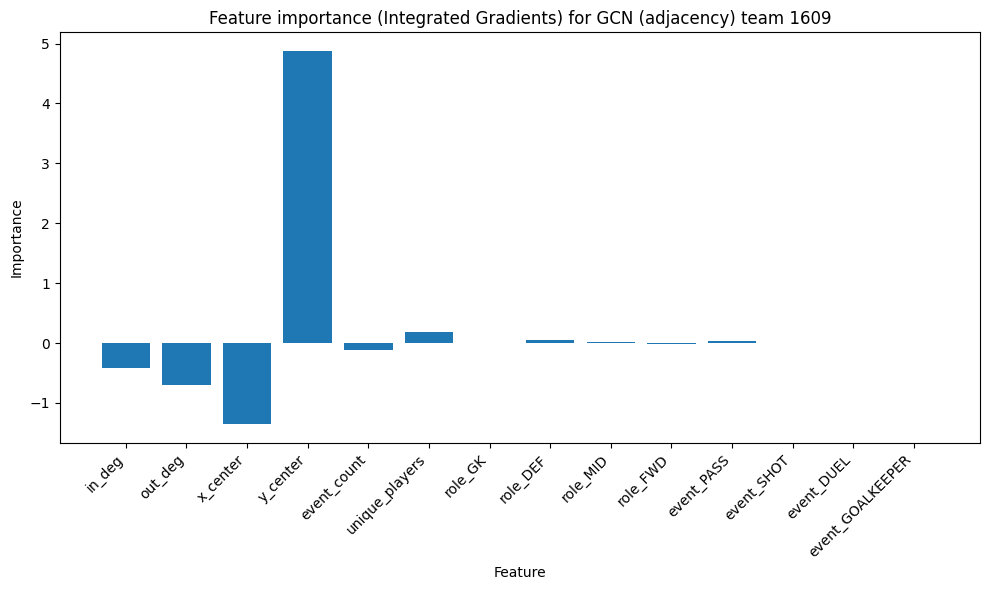

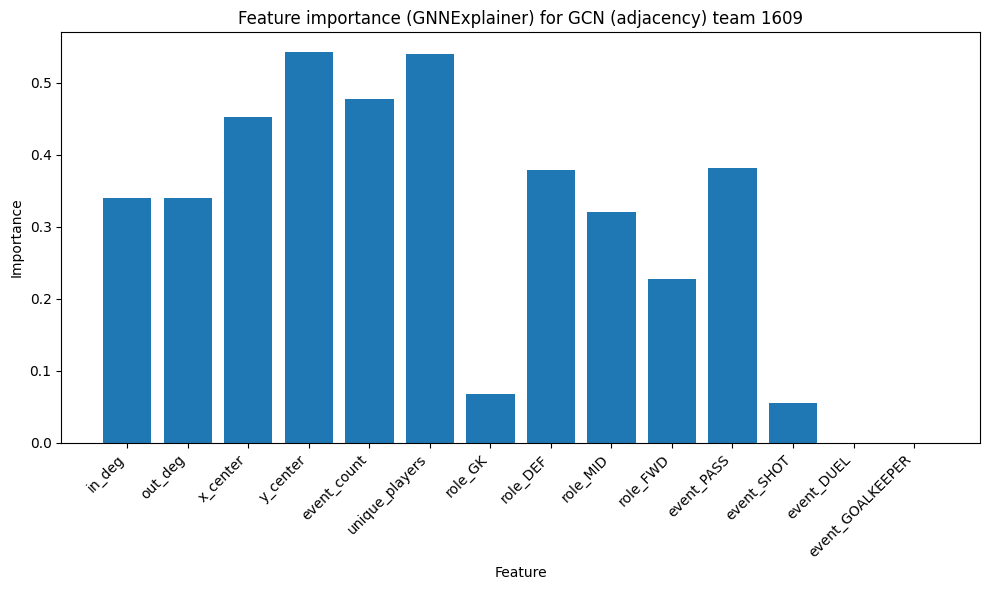

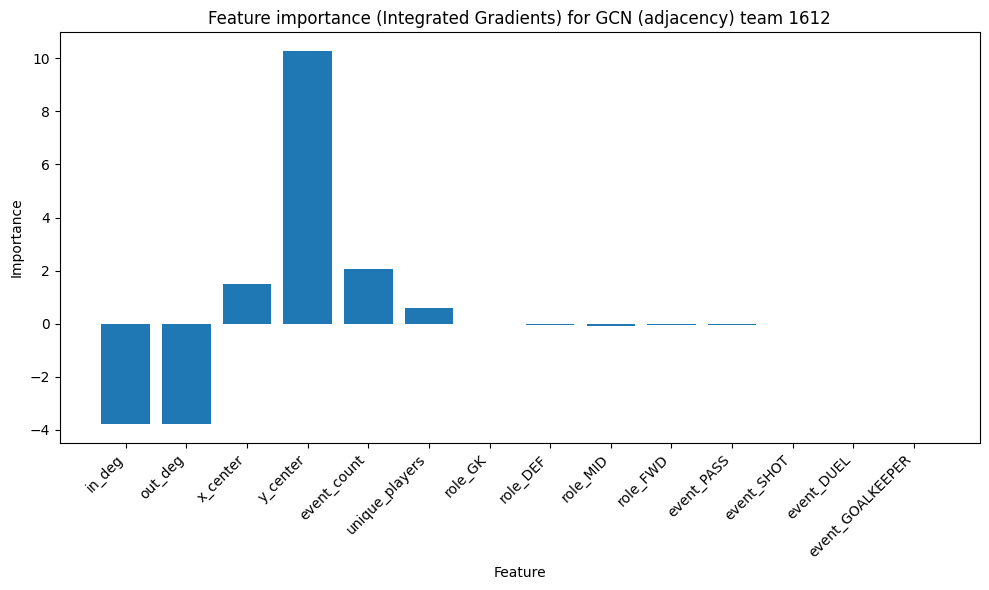

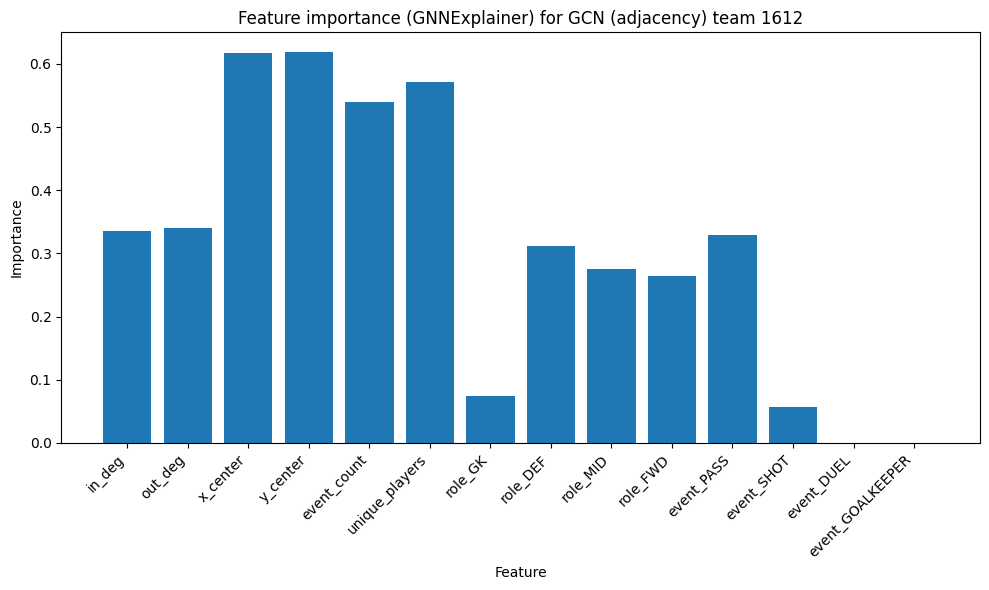

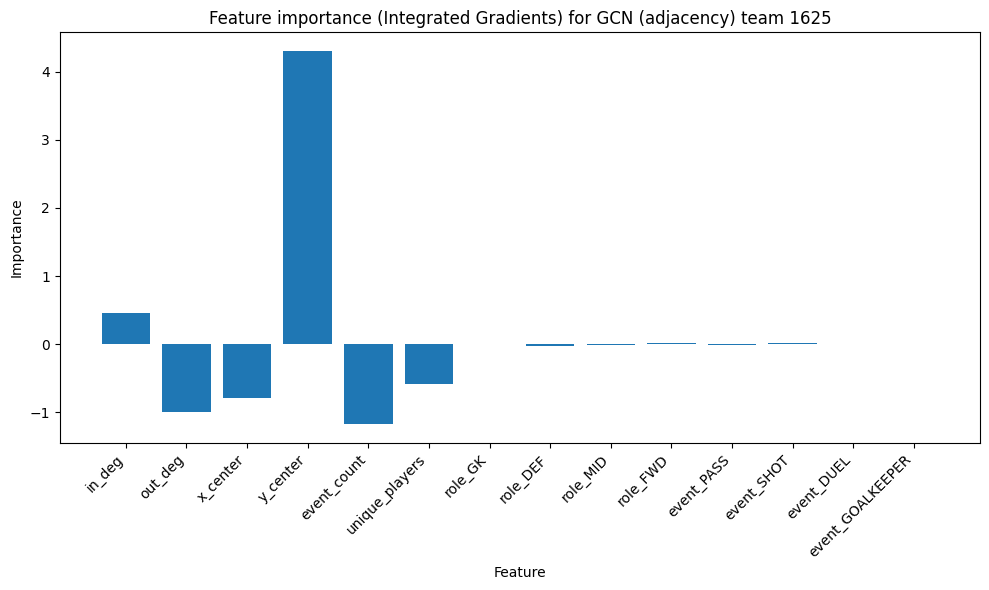

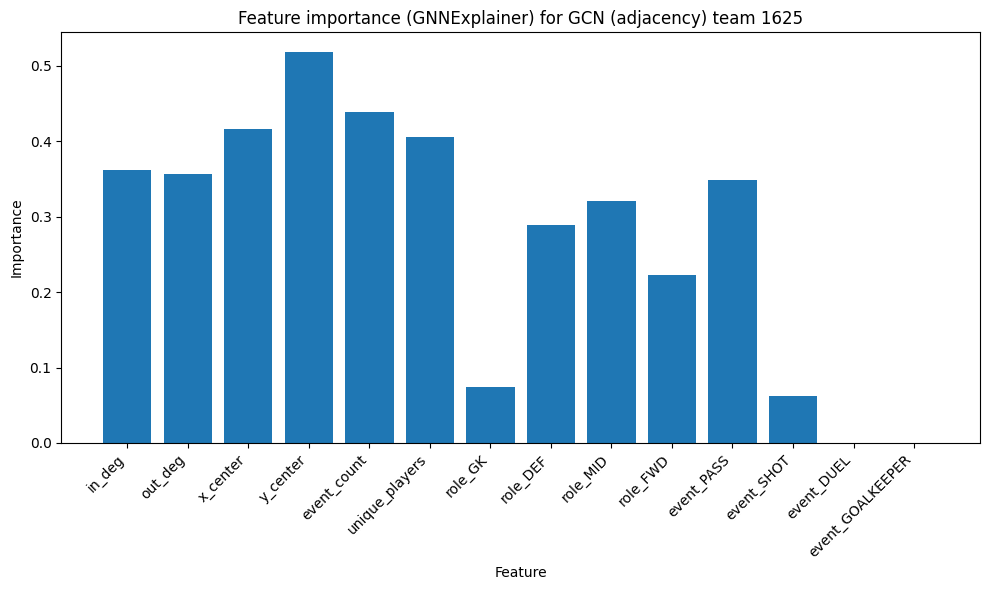

In [47]:
for t in teams:
    # exec(
    #     f"ig_data_{t} = get_global_explainer(integrated_gradients, model_{t}, team={t})"
    # )
    plot_feature_importance(
        eval(f"np.mean(ig_data_{t}['all_masks'], axis=0)"),
        feat_labels,
        title=f"Feature importance (Integrated Gradients) for GCN (adjacency) team {t}",
    ),
    plot_feature_importance(
        eval(f"np.mean(gnn_data_{t}['all_masks'], axis=0)"),
        feat_labels,
        title=f"Feature importance (GNNExplainer) for GCN (adjacency) team {t}",
    )

In [51]:
for t in teams:
    exec(f"ig_fidelity_{t} = np.mean(ig_data_{t}['fidelity'])")
    print(f"Average IG fidelity for team {t}: {eval(f'ig_fidelity_{t}')}")

    exec(f"ig_entropy_{t} = np.mean(mask_entropy(np.array(ig_data_{t}['all_masks'])))")
    print(f"Average IG mask entropy for team {t}: {eval(f'ig_entropy_{t}')}")

    exec(f"gnn_fidelity_{t} = np.mean(gnn_data_{t}['fidelity'])")
    print(f"Average GNNExplainer fidelity for team {t}: {eval(f'gnn_fidelity_{t}')}")
    exec(
        f"gnn_entropy_{t} = np.mean(mask_entropy(np.array(gnn_data_{t}['all_masks'])))"
    )
    print(
        f"Average GNNExplainer mask entropy for team {t}: {eval(f'gnn_entropy_{t}')}\n"
    )

Average IG fidelity for team 1609: 0.771499311797762
Average IG mask entropy for team 1609: 0.7589247822761536
Average GNNExplainer fidelity for team 1609: 0.8452736245811378
Average GNNExplainer mask entropy for team 1609: 3.8775975704193115

Average IG fidelity for team 1612: 0.8122245100301665
Average IG mask entropy for team 1612: 0.34635570645332336
Average GNNExplainer fidelity for team 1612: 0.8539131449686514
Average GNNExplainer mask entropy for team 1612: 3.7676751613616943

Average IG fidelity for team 1625: 0.8870569270708271
Average IG mask entropy for team 1625: 0.42349809408187866
Average GNNExplainer fidelity for team 1625: 0.8977416945243808
Average GNNExplainer mask entropy for team 1625: 3.948213577270508



In [37]:
ig_fidelity

0.8231284555451046

In [41]:
ig_entropy

0.511819

In [43]:
gnn_fidelity

0.8654609535296913

In [45]:
gnn_entropy

3.8646123